In [96]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
from haloclustering.models import Model
import glob
from cgmsquared import clustering as cgm2_cluster
from cgmsquared import load_cgmsquared
import cgmsquared.clustering2 as c2
from astropy.table import Table, vstack
import numpy as np
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: attempted relative import with no known parent package

In [94]:
# cgmsquared
surveyfile = "/Users/mwilde/python/cgm-squared/cgmsquared/data/cgm/cgmsquared_cgmsurvey_aodm_vhalos10_3sigma.json"
ion = 'HI'
cgm = load_cgmsquared.load_cgm_survey(build_sys=False, survey_file=surveyfile)
cgm.add_ion_to_data(ion)

# casbah
survey_files = glob.glob("/Users/mwilde/Dropbox/CASBaH/data/h1_galaxies_20Mpc_500kms_*.fits")
cas_tab_list = []
for cas_tab_file in survey_files:
    tab = Table.read(cas_tab_file)
    # add in useful naming conventions
    tab['rho_rvir'] = tab['rho_impact']/tab['rvir']
    tab['z'] = tab['z_1']
    tab['sig_logN_HI'] = tab['sig_logN']
    cas_tab_list.append(tab)

cgm_data_cas = vstack(cas_tab_list)


# z, rho_com, mass, hits, misses, Hz, dv, cgm_data_doanly, do_anly = c2.combine_cgm2_casbah_cluster_data(cgm, cgm_data_cas)



data = c2.combine_cgm2_casbah_cluster_data(cgm, cgm_data_cas)                                                                                                       

Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 1294
misses 4775
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 268
misses 292


### the new model is defined as such:

 define the models


###  $\chi_{\perp}^{1h} +\chi_{\perp}^{2h}$


$\xi = (r/r_0)^{\gamma}$

where in the 1h term, $r_0 = R_{\rm vir}(m)$, and in the 2-halo term, $r_0$ is a free paramter

$\chi_{\perp} = \int \xi ds$

rate of incidence = $\lambda$



$f_c = 1 - \exp(-\lambda)$

$\lambda = (1 + [\chi_{\perp}^{1h}(r(m)| \gamma^{1h}) + \chi_{\perp}^{2h}(r|r^{2h}_0, \gamma^{2h})])~\langle dN/dz | C_0, \alpha \rangle \delta z$

$\langle dN/dz\rangle = C_0(1 + z)^{\alpha}$


In [52]:
r_0_initial = 1 # clustering scale
r_0_2 = 4
beta_initial = 0.5
beta_2_initial = 0.05
gamma_initial = 6 # clutering powerlaw index
gamma_2_initial = 1.7
b_initial = 1. # additive constant to take care of normalization
dndz_index = 1.2 # dN/dz powerlaw index
dndz_coeff = 17


# m0 = 10**9.5


# theta = np.array([m0, r_0_initial, r_0_2, gamma_initial, gamma_2_initial,  beta_initial, beta_2_initial, dndz_index, dndz_coeff])

theta1h = np.array([gamma_initial])
theta2h = np.array([r_0_2, gamma_2_initial])
thetaz = np.array([dndz_index, dndz_coeff])


In [57]:
RvirModel = Model(data, theta1h=theta1h, theta2h=theta2h, thetaz=thetaz)

In [56]:
RvirModel.phit_sum()

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


(0.0, 1.5)

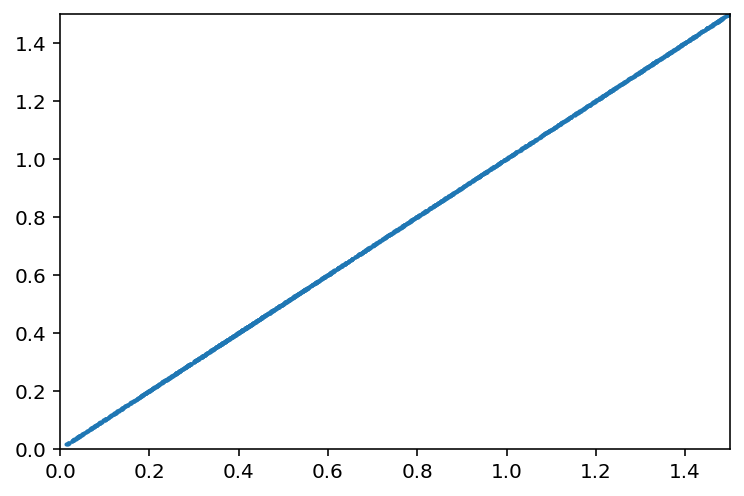

In [48]:
plt.scatter(cgm_data_doanly['rho']/1000/(1 + cgm_data_doanly['z']), cgm_data_doanly['rho_com'], s=1)
plt.xlim(0,1.5)
plt.ylim(0,1.5)

In [91]:
def max_likelihood_est(initial, bounds, model):
        from scipy.optimize import minimize
        # nll = lambda *args: model.neg_log_likelihood(args)
        soln = minimize(model.neg_log_likelihood, x0=initial, bounds=bounds)
        return soln

In [93]:
initial = np.array([gamma_initial, r_0_2, gamma_2_initial, dndz_index, dndz_coeff])

bounds = ((0, 2), (0, 10), (0, 2), (-2, 3), (0, 30))

max_likelihood_est(initial=initial, bounds=bounds, model=RvirModel)

      fun: 3437.8351852010137
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.02846718, -0.00272848,  0.0174623 ,  0.02955858,  0.00077307])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 228
      nit: 28
     njev: 38
   status: 0
  success: True
        x: array([ 0.04579004,  4.63921852,  1.65718876,  1.35072381, 13.88084157])

In [ ]:
# calc rvir for fiducial m and z

import casbah.gal_properties as caprop


In [67]:
# to use to compute r21 change the data to be the fake data
mass = 9.5
redshift = 0.5
npts = 1000
logmhalo = caprop.calchalomass(mass, redshift)
rvir = caprop.calcrvir(logmhalo, redshift)
r_lin = np.geomspace(1e-10, 20, npts)
#m_lin = np.full((npts,1), 10**mass)
linmass = 10**mass
m_lin = np.full(npts, linmass)
# midx_lin = np.digitize(m_lin, [0, 10**lo_edge, 10**hi_edge, 10**13]) - 1
z_lin = np.full(npts, redshift)
Hz_lin = cosmo.H(z_lin).value
dv = 500.
rvir_lin = np.full(npts, rvir)

data = (
    z_lin,
    r_lin,
    m_lin,
    None,
    None,
    Hz_lin,
    dv,
    rvir_lin, # calculate rvir here
    None)

array([[ 6. ,  4. ,  1.7,  1.2, 17. ]])

In [70]:
pos = initial + 1e-4 * np.random.randn(2*initial.shape[0], initial.shape[0])
nwalkers, ndim = pos.shape
import emcee 
sampler = emcee.EnsembleSampler(nwalkers, ndim, RvirModel.log_probability,
                                        args=None)

In [71]:
sampler